# Real data analysis

Now that we know where ultrasound signals come from, let's (re-)analyze real data from a real human brain to see if we can measure (proxies of) neural activity with ultrafast ultrasound images. We'll cover topics including motion compensation and modeling the hemodynamic response. 

Let's load up the data from [Rabut et al. (2024), *A window to the brain: ultrasound imaging of human neural activity through an acoustically transparent cranial prosthetic*](https://www.biorxiv.org/content/10.1101/2023.06.14.544094v1.full.pdf). It's a dataset that captures activity in the motor cortex through a transparent window in a human subject. It illustrates core topics in fUS data analysis.

# Download the data

In [1]:
%%bash
set -euo pipefail

# Download only if data.zip doesn't already exist (and isn't empty)
if [ ! -s data.zip ]; then
  echo "Downloading data.zip…"
  curl -L 'https://data.caltech.edu/records/f3y3k-em558/files/data.zip?download=1' -o data.zip \
    --fail --show-error --silent \
    --continue-at - \                # resume if a partial file exists
    --connect-timeout 20 \           # fail fast if no connection
    --max-time 600 \                 # hard cap (seconds)
    --retry 3 --retry-connrefused \  # a few retries on transient errors
    --speed-time 30 --speed-limit 1024  # abort if <1 KB/s for 30s
else
  echo "data.zip already exists; skipping download."
fi

# Unzip without overwriting existing files
unzip -n data.zip -d data

data.zip already exists; skipping download.
Archive:  data.zip


In [2]:
import h5py
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from numpy.linalg import lstsq
import scipy
import scipy.signal
import scipy.stats
from scipy.stats import gamma as gamma_dist
from scipy.linalg import svd



f = h5py.File('data/data/human/S2R1.mat', 'r')
f

<HDF5 file "S2R1.mat" (mode r)>

In [3]:
f.keys()

<KeysViewHDF5 ['#refs#', 'UF', 'angiogram', 'dop', 'run_label', 'task', 'timestamps']>

The `angiogram` key contains an image which captures the average signal in the volume over the trial.

Text(0.5, 1.0, 'Angiogram')

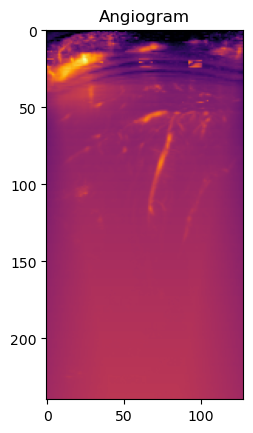

In [4]:
plt.imshow(np.log(f['angiogram'][:].T[:, ::-1]), cmap='inferno')
plt.title("Angiogram")

What are we looking at? Figure 6C helps us interpret this image:

![vascular.png](vascular.png)

At the top is the PMMA implant; then we hit the brain surface; finally, we see the vasculature under the brain surface.

Now let's look at the Power Doppler data.

In [5]:
# Check the shape of the Doppler data
print("Doppler data shape:", f['dop'].shape)

Doppler data shape: (270, 128, 240)


Let's visualize this data over time. We'll skip every third frame so it's faster to render.

In [ ]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(5, 6))

# Get the Doppler data
dop_data = np.log(f['dop'][:][:, ::-1, :]).transpose(0, 2, 1)
n_frames = dop_data.shape[0] // 3

# Initialize the plot with the first frame
im = ax.imshow(dop_data[0, :, :], cmap='inferno')
ax.set_title(f'Frame 0/{n_frames}')
plt.colorbar(im, ax=ax)

# Animation update function
def update(frame):
    im.set_array(dop_data[frame*3, :, :])
    ax.set_title(f'Frame {frame}/{n_frames}')
    return [im]

# Create animation
anim = animation.FuncAnimation(fig, update, frames=n_frames, 
                               interval=50, blit=True, repeat=True)

plt.close(fig)  # Prevents static image display

# Display the animation
HTML(anim.to_jshtml())

Very cool! We see a slice of the brain over time. 

# Dealing with artifacts

The Power Doppler data in this dataset is preprocessed with clutter filtering to mitigate global motion artifacts *within frames*. However, we still see two types of artifacts *across frames* in the data:

* There are high variance pixels at the top of the volume, above the brain surface
* The brain is shifting over time, which is clearly visible if you look at the postcentral sulcus.

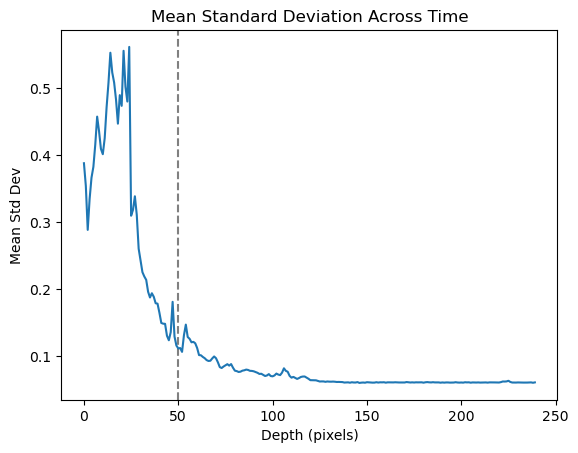

In [7]:
plt.axvline(50, color='gray', linestyle='--')
plt.plot(np.std(dop_data, axis=0).mean(axis=1))
plt.title("Mean Standard Deviation Across Time")
plt.xlabel("Depth (pixels)")
plt.ylabel("Mean Std Dev")
plt.show()

To deal with the first artifact, we'll crop the top of the volume. To deal with the second artifact, we'll use a non-rigid registration method, NoRMCoRR, which is located in the CaImAn package. [CaImAn](https://github.com/flatironinstitute/CaImAn) is a little tricky to install; follow route A in the `README.md` on Github to install it.

To run the package, we'll save an hdf5 file with the corresponding data

In [8]:
# Make sure to select only brain here
# Create a new HDF5 file to save the aligned data
crop = slice(50, -1)
h5f = h5py.File('data_logged_unaligned.h5', 'w')
h5f.create_dataset('dop', data=dop_data[:, crop, :])
h5f.close()

In [9]:
import caiman
from caiman.motion_correction import MotionCorrect

fname = 'data_logged_unaligned.h5'

h5f = h5py.File(fname, 'r')
template = h5f['dop'][:].mean(axis=0)
h5f.close()

max_shifts = (15, 15)
strides = (32, 32)
overlaps = (16, 16)
max_deviation_rigid = 3
shifts_opencv = True
border_nan = 'copy'
upsample_factor_grid = 16

mc = MotionCorrect(fname, 
                   max_shifts=max_shifts,
                   strides=strides, 
                   overlaps=overlaps,
                   max_deviation_rigid=max_deviation_rigid, 
                   shifts_opencv=shifts_opencv, 
                   nonneg_movie=False,
                   border_nan=border_nan,
                   upsample_factor_grid=upsample_factor_grid)

mc.pw_rigid = True

mc.motion_correct(save_movie=True, template=template)

# Load up the motion corrected data
m_els = caiman.load(mc.fname_tot_els)

100%|██████████| 1/1 [00:00<00:00, 59.00it/s]


One sanity check that this worked well is to compare the mean power doppler images before and after.

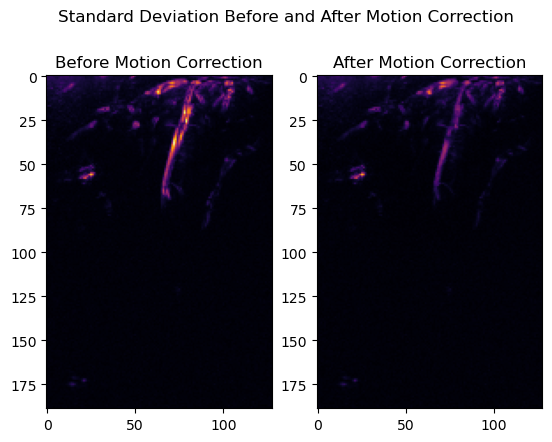

In [10]:
dop_data_std = dop_data[:, crop, :].std(axis = 0)
dop_data_std_aligned = m_els.std(axis=0)

plt.subplot(121)
plt.imshow(dop_data_std, cmap='inferno', vmax=dop_data_std.max(), vmin=dop_data_std.min())
plt.title('Before Motion Correction')
plt.subplot(122)
plt.imshow(dop_data_std_aligned, cmap='inferno', vmax=dop_data_std.max(), vmin=dop_data_std.min())
plt.title('After Motion Correction')
plt.suptitle("Standard Deviation Before and After Motion Correction")
plt.show()

We can see that the standard deviation has been suppressed, especially around that big central artery, which seems to exhibit less ghosting after motion correction.

In [ ]:
# Create figure and axis
fig, (ax1, ax2) = plt.subplots(figsize=(8, 6), ncols=2)

dop_data_cropped = dop_data[:, crop, :]

# Get the Doppler data
n_frames = dop_data.shape[0] // 3

# Initialize the plot with the first frame
im1 = ax1.imshow(dop_data_cropped[0, :, :], cmap='inferno', vmin=dop_data_cropped.min(), vmax=dop_data_cropped.max())
im2 = ax2.imshow(m_els[0, :, :], cmap='inferno', vmin=dop_data_cropped.min(), vmax=dop_data_cropped.max())
ax1.set_title(f'Before')
ax2.set_title(f'After')

# Animation update function
def update(frame):
    im1.set_array(dop_data_cropped[frame*3, :, :])
    im2.set_array(m_els[frame*3, :, :])
    return [im1, im2]

# Create animation
anim = animation.FuncAnimation(fig, update, frames=n_frames, 
                               interval=50, blit=True, repeat=True)

plt.close(fig)  # Prevents static image display

# Display the animation
HTML(anim.to_jshtml())

It's not perfect, but we definitely see an improvement in the stability of the volume.

# Modeling the neural response

Let's now try to recover the neural response over time. Let's first look at the trial structure:

Text(0, 0.5, 'Motion on')

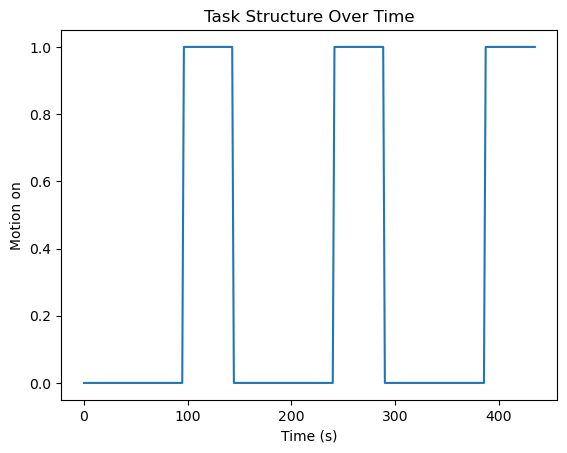

In [12]:
plt.plot(f['timestamps'][:][0, :], f['task'][:])
plt.title("Task Structure Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Motion on")

At times when the `task` variable is set to 1, the patient is instructed to move a joystick to trace out a figure. Thus, we expect that there will be lagged activity in their motor cortex. Let's first examine the singular vectors of the data to see if the image seems to track the trial structure.

In [13]:
m_els.shape

(270, 189, 128)

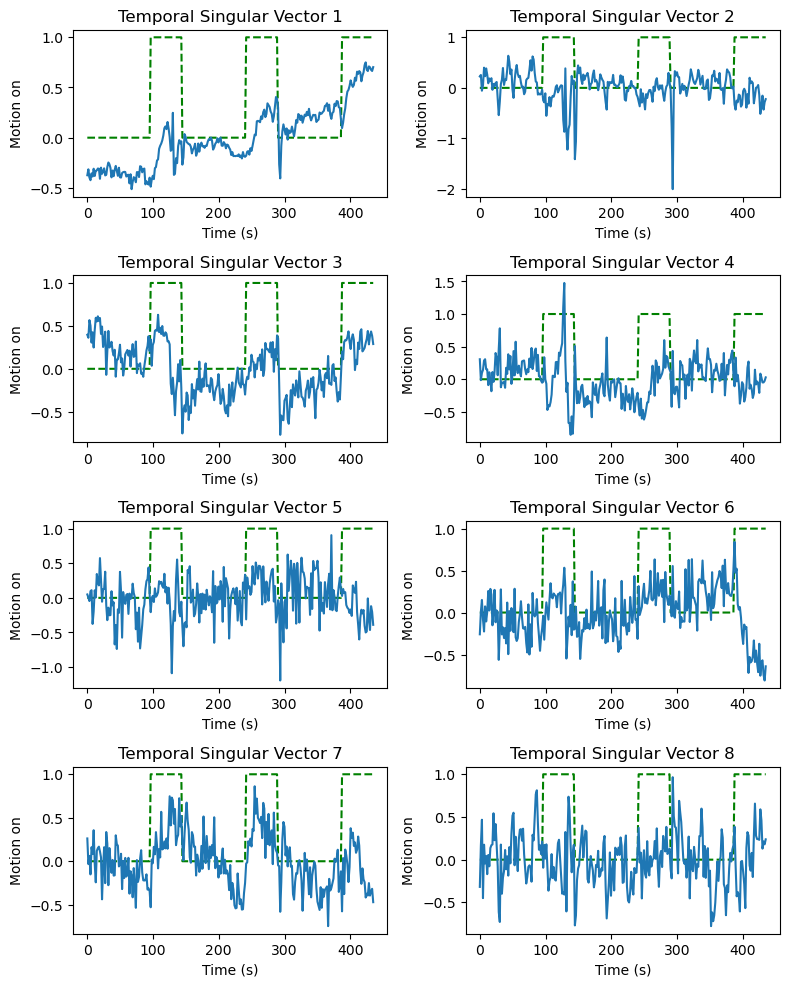

In [14]:
A = m_els.reshape(m_els.shape[0], -1)

U, S, V = svd(A - A.mean(axis=0, keepdims=True), full_matrices=False)
plt.figure(figsize=(8, 12))
for i in range(8):
    plt.subplot(5, 2, i+1)
    plt.plot(f['timestamps'][:][0, :], f['task'][:], 'g--')
    plt.plot(f['timestamps'][:][0, :], U[:, i] * 5)
    plt.title("Task Structure Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Motion on")

    plt.title(f'Temporal Singular Vector {i+1}')
plt.tight_layout()

That looks promising---we definitely see the signal waxing and waning in sync with the trial structure. 

## Estimating the time lag between task onset and neural activity

Notice that the peaks seem a bit lagged compared with the start of the "on" periods---this is in line with what we expect from the hemodynamic responses function, which tends to lag neural activity. A coarse way to determine the lag between neural activity and functional activity is to run a regression between lagged task indicators and the PD signals. The quality of the fit ($R^2$) tells us how aligned the two time-series are, giving us a coarse measure of optimal time lag. Note that we add a linear confounder to the regression to deal with drift; we could also add more confounders for faster drifts.

In [15]:
Y = np.array(m_els).reshape(m_els.shape[0], -1)
Y = Y - Y.mean(axis=0, keepdims=True) / Y.std(axis=0, keepdims=True)

rs = []
r0 = f['task'][:].squeeze()
lags = np.arange(-10, 10)
for lag in lags:
    r = np.roll(r0, lag)
    if lag > 0:
        r[:lag] = 0
    elif lag < 0:
        r[lag:] = 0
    X = np.column_stack((r, np.ones_like(r), np.arange(len(r))))
    B, residuals, rank, s = lstsq(X, Y, rcond=None)
    rs.append(residuals)

B_base, residuals_base, rank, s = lstsq(X[:, -2:], Y, rcond=None)

Text(0.5, 1.0, 'Mean R² vs Lag between Task and PD Signals')

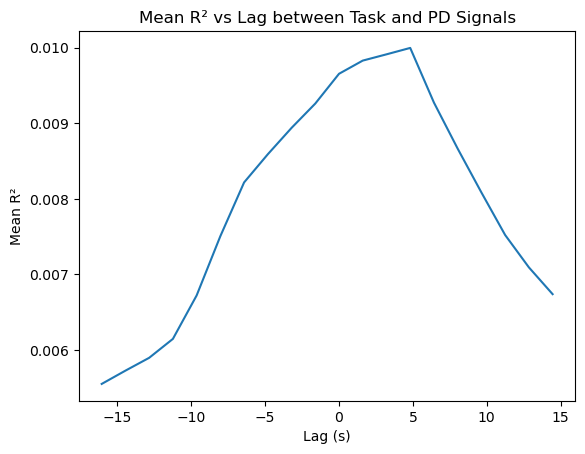

In [16]:
dt = f['timestamps'][0, 1] - f['timestamps'][0, 0]
r2s = (1 - np.array(rs).T / residuals_base.reshape((-1, 1)))
plt.plot(lags * dt, r2s.mean(axis=0))
plt.xlabel("Lag (s)")
plt.ylabel("Mean R²")
plt.title("Mean R² vs Lag between Task and PD Signals")

The optimal lag seems to be around 5 seconds, which is right in line with the [hemodynamic literature](https://pmc.ncbi.nlm.nih.gov/articles/PMC3318970/). In fact, the "canonical HRF" implemented in SPM---a classic Matlab-based analysis toolbox---which is given by a sum of two gamma functions, peaks at about 5 seconds.

Text(0.5, 1.0, 'Canonical Hemodynamic Response Function (HRF)')

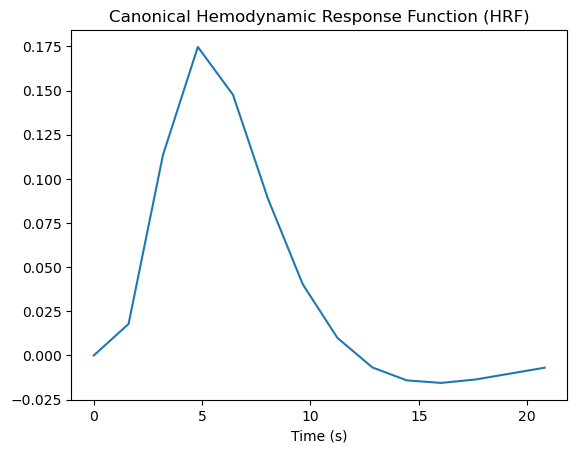

In [17]:
def canonical_hrf_and_derivs_scipy(
    t,
    peak_delay=6.0,       # seconds
    under_delay=16.0,     # seconds
    peak_disp=1.0,        # scale (θ)
    under_disp=1.0,       # scale (θ)
    p_u_ratio=6.0,        # peak-to-undershoot amplitude ratio
    onset=0.0,            # onset shift (s)
    normalize_area=True   # normalize ∫h(t)dt = 1 over provided t
):
    """
    Canonical (SPM-style) HRF and its first and second *temporal* derivatives at timestamps t,
    using SciPy's gamma pdf.

    h(t) = g1(t) - (1/p_u_ratio) * g2(t)
    where g1 ~ Gamma(k1, θ1), g2 ~ Gamma(k2, θ2),
    with k ≈ delay/disp and θ = disp. Derivatives are analytical.

    Returns
    -------
    h, h1, h2 : np.ndarray
        HRF, dh/dt, d²h/dt² evaluated at t.
    """
    t = np.asarray(t, dtype=float)
    tt = np.clip(t - onset, a_min=0.0, a_max=None)

    # Convert delays/dispersion to Gamma(shape k, scale θ)
    k1, th1 = peak_delay / peak_disp, peak_disp
    k2, th2 = under_delay / under_disp, under_disp

    # Gamma pdfs via SciPy (shape=a=k, scale=θ). Support t=0 by zeroing negatives.
    g1  = gamma_dist.pdf(tt, a=k1, scale=th1)
    g2  = gamma_dist.pdf(tt, a=k2, scale=th2)

    # Analytical time-derivatives of the gamma pdf:
    # f'(t) = ((k-1)/t - 1/θ) f(t)
    # f''(t) = [ - (k-1)/t^2 + ((k-1)/t - 1/θ)^2 ] f(t)
    eps = 1e-12
    inv_t = 1.0 / np.maximum(tt, eps)

    coef1 = (k1 - 1.0) * inv_t - (1.0 / th1)
    coef2 = (k2 - 1.0) * inv_t - (1.0 / th2)

    g1d  = coef1 * g1
    g2d  = coef2 * g2
    g1dd = (-(k1 - 1.0) * inv_t**2 + coef1**2) * g1
    g2dd = (-(k2 - 1.0) * inv_t**2 + coef2**2) * g2

    h  = g1  - (1.0 / p_u_ratio) * g2
    h1 = g1d - (1.0 / p_u_ratio) * g2d
    h2 = g1dd - (1.0 / p_u_ratio) * g2dd

    # Zero everything prior to onset exactly (optional but tidy)
    pre = (t < onset)
    if pre.any():
        h[pre] = 0.0
        h1[pre] = 0.0
        h2[pre] = 0.0

    return h, h1, h2

hrf, hrf_dt, hrf_ddt = canonical_hrf_and_derivs_scipy(f['timestamps'][:][0, :14])
plt.plot(f['timestamps'][:][0, :14], hrf, label='Canonical HRF')
plt.xlabel('Time (s)')
plt.title('Canonical Hemodynamic Response Function (HRF)')

Now, the HRF is just an average, and in reality some pixels are going to light up "faster" than others. While we could try to estimate the full HRF at every time lag for every pixel, the conditioning of the resulting design matrix will be bad, and we'll need to heavily regularize the weights. A middle ground between an inflexible canonical HRF and estimating the full HRF is to add time derivatives of the canonical HRF to the regression. Indeed, an HRF temporally shifted by $\tau$ is approximately given by:

$$f(t - \tau) \approx f(t) + \tau f'(t) + \frac{1}{2}\tau^2 f''(t) + \ldots$$

Thus, we'll add the first and second temporal derivatives of the HRF to our regression.

In [18]:
r_hrf = scipy.signal.convolve(f['task'][:][:, 0], hrf, mode='full')[:len(f['task'])]
r_hrfp = scipy.signal.convolve(f['task'][:][:, 0], hrf_dt, mode='full')[:len(f['task'])]
r_hrfpp = scipy.signal.convolve(f['task'][:][:, 0], hrf_ddt, mode='full')[:len(f['task'])]

In [19]:
Y = m_els.reshape(m_els.shape[0], -1)
Y = Y / Y.std(axis=0)
X = np.vstack([r_hrf, r_hrfp, r_hrfpp, np.ones_like(r_hrfp), np.arange(len(r_hrfp)) /len(r_hrfp)]).T

B, residuals, rank, s = lstsq(X, Y, rcond=None)
B_baseline, residuals_baseline, rank, s = lstsq(X[:, -2:], Y, rcond=None)
r2 = 1 - residuals / residuals_baseline

Let's overlay the $R^2$ map with the mean PD image.

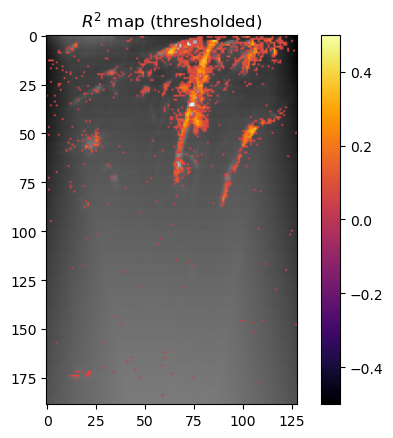

In [20]:
threshold = 0.05 # Totally arbitrary
meets_threshold = 1.0 * ((1 - residuals / residuals_baseline) > threshold)

plt.imshow(m_els.mean(axis=0), cmap='gray')
plt.imshow((1 - residuals / residuals_baseline).reshape(m_els.shape[1], m_els.shape[2]), alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]), clim=(-.5, .5), cmap='inferno')
plt.title("$R^2$ map (thresholded)")
plt.colorbar()

We see that most of the pixels which are modulated by the task are around the visible arteries.

# What about p-values?

Are these $R^2$ values good? I'm not a big fan of using p-values as a litmus test to determine whether a model is "significant" or not. It is, however, useful to get at least some idea of whether or not our model is better than the null. We can scramble or time-shift the design matrix to obtain a null distribution and calculate a p-value from that; alternatively, we can use a classical test like the F-test.

In [21]:

F_obs = ( (residuals_baseline - residuals) / 3 ) / ( residuals / (Y.shape[0] - X.shape[1]) )
d1 = 3
d2 = Y.shape[0] - d1 - 1

Text(0.5, 1.0, 'F stat distribution vs. observed statistics')

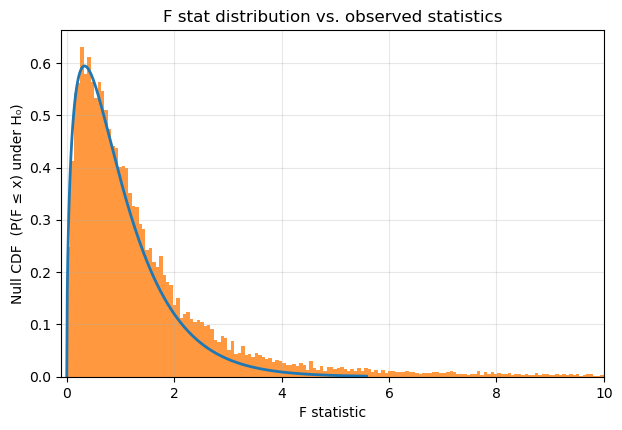

In [22]:
# x-range (up to ~99.9th percentile so the CDF reaches ~1)
xmax = scipy.stats.f.ppf(0.999, d1, d2)
xs = np.linspace(0, xmax, 600)

# null CDF under H0
cdf = scipy.stats.f.pdf(xs, d1, d2)        # F_{d1,d2}(x)

plt.figure(figsize=(7,4.5))
plt.plot(xs, .82* cdf, linewidth=2)
plt.xlabel("F statistic")
plt.ylabel("Null CDF  (P(F ≤ x) under H₀)")
plt.grid(True, alpha=0.3)
_ = plt.hist(F_obs, bins=1000, density=True, alpha=0.8, label='Observed F statistics')
plt.xlim((-.1, 10))
plt.title(f"F stat distribution vs. observed statistics")


As we can see, there's a lot of excess weight on the right side of the distribution compared to the null F-distribution. Those correspond to R^2 values greater than expected by chance, i.e. significantly modulated pixels.

Great, now let's see some p-values.

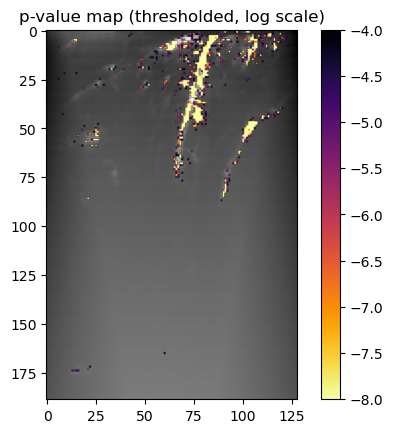

In [23]:
p = scipy.stats.f.sf(F_obs, dfn=d1, dfd=d2)
threshold = 0.0001 # Totally arbitrary
meets_threshold = 1.0 * (p < threshold)

plt.imshow(m_els.mean(axis=0), cmap='gray')
plt.imshow((np.log10(p)).reshape(m_els.shape[1], m_els.shape[2]), alpha=meets_threshold.reshape(m_els.shape[1], m_els.shape[2]), clim=(np.log10(1e-8), np.log10(threshold)), cmap='inferno_r')
plt.title("p-value map (thresholded, log scale)")
plt.colorbar()

No surprise here, we find that the computed p-values are tiny around the arteries in the volume.

# References

* [Rabut et al. 2024](https://www.biorxiv.org/content/10.1101/2023.06.14.544094v1.full.pdf). *A window to the brain: ultrasound imaging of human neural activity through an acoustically transparent cranial prosthetic*